In [ ]:
import pandas as pd
from unidecode import unidecode
import Levenshtein as lev
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# Анализ авторынка Казахстана

Целью проекта является анализ авторынка Республики Казахстан.

Описание данных: В нашем распоряжении "сырые" данные по продажам автомобилей в Казахстане за 2019 год. Данные получены из
официальной статистики, после перевода из эксель в csv обнаружились множественные
проблемы с исходными данными: некорректные разделители десятичных разрядов, несоответствие
данных типу данных. Дополнительной проблемой является то, что статистику собирал не один
человек, поэтому есть неявные дубликаты, а также одни и те же
признаки могут быть записаны как на русском, так и на английском языке.  

План работы:
1. Очистка данных.   
    1.1 Загрузка данных.      
    1.2 Избавиться от лишних столбцов.    
    1.3 Избавиться от неявных дубликатов в столбцах.
    1.4 Анализ, изменение типов данных.
    1.5 Анализ пропусков.
    1.6 Избавление от аномалий в столбцах. 
2. Исследовательский анализ.  
    2.1 Признаки столбцов.     
    2.2 Анализ строк. 
    2.3 Анализ полных дубликатов.      
    2.5 Кодирование столбцов. 
    2.7 Анализ числовых признаков.  
    2.8 Анализ категориальных признаков.
3. Анализ рынка.   
    3.1 Топовые марки на рынке Казахстана.  
    3.2 Продажи на рынке Казахстана всех марок в денежном и натуральном выражении.  
    3.3 Динамика продаж в целом по рынку (помесячно).  
    3.4 Динамика продаж по категориям (помесячно): тип топлива, класс, сегмент.  
    3.5 Продажи по регионам.  
    3.6 Продажи по автоцентрам. 

## Очистка данных

In [2]:
#загрузим датасет
file_path = 'C:\\Users\\Redmi\\Desktop\\projects\\automarket_KZ\\auto_kz_2019.csv'
df = pd.read_csv(file_path, sep = ';',decimal=",")
display(df.head())

,Год,Месяц,Компания,Бренд,Модель,Модификация,Год выпуска,Страна-производитель,Вид топлива,"Объём двиг, л,",...,Тип клиента,Форма расчета,Количество,"Цена, USD","Продажа, USD",Область,Сегментация 2013,Класс 2013,Сегментация Eng,Локализация производства
0,2019,Май,Mercur Auto,Audi,A3,TFSI,2018,Германия,Бензин,"1,4",...,Физ. Лицо,безналичный,1.0,28115.00,28115.00,г.Алматы,Легковые автомобили,C класс,C,Импорт
1,2019,Август,Mercur Auto,Audi,A3,TFSI,2018,Германия,Бензин,"1,4",...,Юр. Лицо,наличный,1.0,32246.99,32246.99,г.Алматы,Легковые автомобили,C класс,C,Импорт
2,2019,Апрель,Mercur Auto,Audi,A4,TFSI,2018,Германия,Бензин,"1,4",...,Физ. Лицо,безналичный,1.0,32000.00,32000.00,г.Алматы,Легковые автомобили,D класс,D,Импорт
3,2019,Июль,Mercur Auto,Audi,A4,TFSI,2018,Германия,Бензин,"1,4",...,Юр. Лицо,безналичный,1.0,31929.00,31929.00,г.Алматы,Легковые автомобили,D класс,D,Импорт
4,2019,Июль,Mercur Auto,Audi,A4,TFSI,2018,Германия,Бензин,"1,4",...,Физ. Лицо,наличный,1.0,31929.00,31929.00,г.Алматы,Легковые автомобили,D класс,D,Импорт


In [3]:
# Приводим названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
# Замена пробелов и дефисов на нижние подчеркивание
df.columns = df.columns.str.replace('[ \-]', '_', regex=True)
# Замена запятых  и пробелов с запятыми на пробелы
df.columns = df.columns.str.replace('[ ,\,]', '', regex=True)

In [4]:
#перевод названия столбцов на английский
translation_dict = {
    'год': 'year',
    'месяц': 'month',
    'компания': 'company',
    'бренд': 'brand',
    'модель': 'model',
    'модификация': 'modification',
    'год_выпуска': 'manufacturing_year',
    'страна_производитель': 'manufacturer_country',
    'вид_топлива': 'fuel_type',
    'объём_двиг_л': 'engine_capacity_liters',
    'коробка_передач': 'transmission_type',
    'тип_привода': 'drive_type',
    'сегмент': 'segment',
    'регион': 'region',
    'наименование_дилерского_центра': 'dealer_center_name',
    'тип_клиента': 'customer_type',
    'форма_расчета': 'payment_form',
    'количество': 'quantity',
    'цена_usd': 'price_usd',
    'продажа_usd': 'sale_usd',
    'область': 'area',
    'сегментация_2013': 'segmentation_2013',
    'класс_2013': 'class_2013',
    'сегментация_eng': 'segmentation_eng',
    'локализация_производства': 'production_localization'
}
# Применяем перевод названий столбцов
df = df.rename(columns=translation_dict)

По какой-то причине в столбце с объёмом двигателя разделитель не поменялся на точку, сделаем замену методом replace.

In [5]:
# Преобразование столбца engine_capacity_liters с заменой запятых на точки
df['engine_capacity_liters'] = df['engine_capacity_liters'].str.replace(',', '.')


In [6]:
#удалим ненужные столбцы
df = df.drop(['modification', 'segment', 'dealer_center_name', 'payment_form', 'segmentation_eng', 'production_localization'], axis=1)

In [7]:
#посмотрим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39966 entries, 0 to 39965
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    39966 non-null  int64  
 1   month                   39966 non-null  object 
 2   company                 39966 non-null  object 
 3   brand                   39966 non-null  object 
 4   model                   39966 non-null  object 
 5   manufacturing_year      39465 non-null  object 
 6   manufacturer_country    39966 non-null  object 
 7   fuel_type               36826 non-null  object 
 8   engine_capacity_liters  35708 non-null  object 
 9   transmission_type       36711 non-null  object 
 10  drive_type              35677 non-null  object 
 11  region                  39966 non-null  object 
 12  customer_type           32919 non-null  object 
 13  quantity                39960 non-null  float64
 14  price_usd               39966 non-null

В датасете 39966 строк, 19 столбцов, 4 столбца числовые, остальные типа object.

Описание столбцов:
* year – год продажи (2019)  Он важен для создания даты.
* month – месяц продажи (январь - сентябрь) - важный столбец для оценки объёмов продаж в зависимости от сезонности.
* company – название автоцентра, в котором продана машина - важный столбец, например, для оценки наиболее рентабельных автоцентров. 
* brand – название продаваемой марки автомобиля - важный столбец, потому что необходимо знать, какие бренды чаще или реже продвются.  
* model – название модели автомобиля - важный столбец для анализа популярности моделей.
* manufacturing_year – год производства автомобиля - важный столбец для оценки возраста авто.
* manufacturer_country – страна, где произведен автомобиль (в большинстве случаев это страна расположения завода, а не производитель)  - важный столбец для оценки предпочтений стран-производителей среди покупателей.
* fuel_type – бензин, дизель, электричество, гибрид. Столбец важен для оценки предпочтений по виду топлива.
* engine_capacity_liters – объем двигателя автомобиля в литрах. Важен для анализа характеристик авто и предпочтений покупателей. 
* transmission_type – тип коробки переключения передач. Важен для оценки предпочтений по типу трансмиссии среди потребителей.
* drive_type – тип привода. Важен для оценки предпочтений по типу привода среди потребителей.
* region – регион продажи - важный столбец, так как нам необходимо знать, в каких регионах лучше или хуже продаются авто. 
* quantity – количество автомобилей в заказе - важный столбец, благодаря ему, например, можно посчитать среднее количество машин в 1 чеке и объёмов продаж.   
* price_usd – цена автомобиля USD  - важный столбец для анализа ценовых характеристик, например, для сравнения цен на авто в разных автоцентрах.  
* sale_usd – цена заказа USD (цена авто умноженная на количество и за вычетом скидок если есть)  - важный столбец, например, для подсчёта выручки или среднего чека. 
* area – область продажи - важный столбец для оценки продаж по регионам и влияния географических факторов.
* segmentation_2013 – сегмент автомобиля, важен для оценки предпочтений среди покупателей по сегментам.
* class_2013 – класс автомобиля, столбец важен для анализа предпочтений потребителей по классам авто.

Связанные столбцы:
* Бренд и модель.
* Количество машин и итоговая цена продажи.
* Тип топлива, объём двигателя, тип трансмиссии и вид привода - могут быть связаны, так как определяют характеристики двигателя.

In [8]:
#посмотрим количество пропусков
df.isna().sum()

year                         0
month                        0
company                      0
brand                        0
model                        0
manufacturing_year         501
manufacturer_country         0
fuel_type                 3140
engine_capacity_liters    4258
transmission_type         3255
drive_type                4289
region                       0
customer_type             7047
quantity                     6
price_usd                    0
sale_usd                     0
area                         0
segmentation_2013            0
class_2013                   0
dtype: int64

In [9]:
#удалим строки, где в quantity пропуски
df=df.dropna(subset=['quantity'])
#проверим изменения
df.quantity.count()

39960

Пропуски:  
В столбцах с критически важными данными для анализа рынка пропусков нет. 

Вероятно, для каждой продажи существовал разный набор доступных характеристик. В результате, некоторые столбцы содержат пропущенные значения, так как соответствующие характеристики могли быть недоступны или не были заполнены в отчетности. В столбцах manufacturing_year fuel_type, engine_capacity_liters,transmission_type и drive_type часть пропусков можно восстановить на основе имеющихся данных. А часть возможно восстановить вручную, но это займёт много времени. Учитывая, что эти столбцы не сильно важны для исследования, их можно оставить как есть или поставить заглушки в виде 0.  В этих столбцах пропуски типа MAR.

В customer_type данные не удастся восстановить и пропуски можно интерпретировать как отсутствующий тип или категорию, такие пропуски можно классифицировать как MNAR. Тут применим заглушки в виде нулей.

In [10]:
#заменим пропуски похожими значениями 
model_brand_values = df.groupby(['model', 'brand']).agg({
    'manufacturing_year':'first',
    'fuel_type': 'first',
    'engine_capacity_liters': 'first',
    'transmission_type': 'first',
    'drive_type': 'first'
}).reset_index()

# заполнение пропусков в исходном фрейме данных с использованием словаря
df = df.merge(model_brand_values, on=['model', 'brand'], suffixes=('', '_fill'))

# заполнение пропусков в столбцах исходного фрейма данными из столбцов с суффиксом "_fill"
df['manufacturing_year'].fillna(df['manufacturing_year_fill'], inplace=True)
df['fuel_type'].fillna(df['fuel_type_fill'], inplace=True)
df['engine_capacity_liters'].fillna(df['engine_capacity_liters_fill'], inplace=True)
df['transmission_type'].fillna(df['transmission_type_fill'], inplace=True)
df['drive_type'].fillna(df['drive_type_fill'], inplace=True)

# Удаление временных столбцыов
df.drop(['fuel_type_fill', 'engine_capacity_liters_fill', 'transmission_type_fill', 'drive_type_fill'], axis=1, inplace=True)
#просмотр оставшихся пропусков
df.isna().sum()

year                          0
month                         0
company                       0
brand                         0
model                         0
manufacturing_year            6
manufacturer_country          0
fuel_type                   899
engine_capacity_liters     1806
transmission_type          1130
drive_type                 1209
region                        0
customer_type              7041
quantity                      0
price_usd                     0
sale_usd                      0
area                          0
segmentation_2013             0
class_2013                    0
manufacturing_year_fill       6
dtype: int64

При восстановлении пропусков предполагалось, что одинковые модели имеют одинаковые характеристики.  
Удалось восстановить:  
все пропуски в manufacturing_year  
в fuel_type восстановилось 2241 значений  
в engine_capacity_liters - 2452  
в transmission_type - 2125  
в drive_type - 3080  

До того, как поставить заглушки в виде 0 надо посмотреть для каких моделей и брендов в engine_capacity_liters стоит 0 и сколько таких строк.

In [11]:
filtered_df = df.query('engine_capacity_liters == "0"')[['brand', 'model']]
num_rows = len(filtered_df)

print("Количество строк:", num_rows)
print("Уникальные значения по столбцам 'brand' и 'model':")
print(filtered_df.drop_duplicates())

Количество строк: 438
Уникальные значения по столбцам 'brand' и 'model':
         brand    model
24986  Renault  Sandero


Можно попробовать восстановить значение объёма двигателя для авто Renault  Sandero и благодаря этому заполнить 438 значений

In [12]:
df.query('brand == "Renault" and model == "Sandero" and engine_capacity_liters=="0"').head()

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,manufacturing_year_fill
24986,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,NaN,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018
24987,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,NaN,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24988,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,NaN,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24989,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Уральск,NaN,1.0,12476.89637,12476.89637,Западно-Казахстанская область,Легковые автомобили,B класс,2018
24990,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,NaN,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018


Видно, что в fuel_type попало значение двигателя , а в engine_capacity_liters, transmission_type и drive_type значения 0. Можно перезаписать значения в engine_capacity_liters на 1.6, а в fuel_type на Бензин, а в transmission_type на MT.

In [13]:
df.loc[df['fuel_type'] == "1,6", 'engine_capacity_liters'] = 1.6
df.loc[(df['brand'] == "Renault") & (df['model'] == "Sandero"), 'fuel_type'] = df.loc[(df['brand'] == "Renault") & (df['model'] == "Sandero"), 'fuel_type'].str.replace('1,6', 'Бензин')
df.loc[(df['brand'] == "Renault") & (df['model'] == "Sandero"), 'transmission_type'] = df.loc[(df['brand'] == "Renault") & (df['model'] == "Sandero"), 'transmission_type'].str.replace('0', 'MT')

Значения заменились корректно, теперь заменим оставшиеся пропуски   
(fuel_type                   899  
engine_capacity_liters     1806  
transmission_type          1130  
drive_type                 1209  
customer_type              5518) на 0 и удалим пробелы в значениях всех строковых столбцов

In [14]:
#заменим пропуски
def fill_missing_values(df_to_fill, columns_to_fill):
    for column in columns_to_fill:
        df_to_fill[column] = df_to_fill[column].fillna('0')
    return df_to_fill

# Применим функцию к DataFrame
columns_to_fill = ['manufacturing_year', 'fuel_type', 'engine_capacity_liters', 'transmission_type', 'drive_type','customer_type']
df = fill_missing_values(df, columns_to_fill)
df.isna().sum()

year                       0
month                      0
company                    0
brand                      0
model                      0
manufacturing_year         0
manufacturer_country       0
fuel_type                  0
engine_capacity_liters     0
transmission_type          0
drive_type                 0
region                     0
customer_type              0
quantity                   0
price_usd                  0
sale_usd                   0
area                       0
segmentation_2013          0
class_2013                 0
manufacturing_year_fill    6
dtype: int64

In [15]:
# удаление лишних пробелов в конце значений строковых столбцов
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.replace(r' $', '', regex=True)

Поиск неявных дубликатов в коротких и числовых значениях сложно автоматизировать, но для поиска дублей в длинных стороковых значениях (у нас такими являются company и customer_type) можно написать функцию.

In [16]:
#функция для поиска неявных дублей
def translate_and_find_similar(df, columns_to_compare):
    def similar_values(value1, value2):
        value1_lower = unidecode(value1).lower()
        value2_lower = unidecode(value2).lower()
        return lev.distance(value1_lower, value2_lower) <= 2
    for column in columns_to_compare:
        if df[column].dtype == "object":
            unique_values = df[column].unique()
            num_unique_values = len(unique_values)
            for i in range(num_unique_values):
                for j in range(i + 1, num_unique_values):
                    value1, value2 = unique_values[i], unique_values[j]
                    if similar_values(value1, value2):
                        print(f"Similar values found in '{column}': '{value1}' and '{value2}'")
# Список столбцов, по которым нужно искать похожие значения
columns_to_compare = ['company','customer_type']
# Применение функции
print("Неявные дубликаты:")
translate_and_find_similar(df, columns_to_compare)

Неявные дубликаты:
Similar values found in 'company': 'Mercur Auto' and 'Mercur Autos'
Similar values found in 'company': 'Caspian Motors' and 'Каспиан Моторс'
Similar values found in 'company': 'Autokapital' and 'Автокапитал'
Similar values found in 'company': 'ММС Рус' and 'MMC RUS'
Similar values found in 'company': 'Равон Моторс Казахстан' and 'Ravon Motors Kazakstan'
Similar values found in 'customer_type': 'Физ. Лицо' and 'физ.лицо'
Similar values found in 'customer_type': 'Физ. Лицо' and 'ФизЛицо'
Similar values found in 'customer_type': 'Юр. Лицо' and 'Юр.Лицо'
Similar values found in 'customer_type': 'Юр. Лицо' and 'ЮрЛицо'
Similar values found in 'customer_type': 'Юр.Лицо' and 'ЮрЛицо'
Similar values found in 'customer_type': 'физ.лицо' and 'ФизЛицо'


In [17]:
# функция для просмотра уникальных значений во всех столбцах в ручную
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    print(f"Уникальные значения в '{column}': {unique_values}\n")

Уникальные значения в 'year': [2019]

Уникальные значения в 'month': ['Август' 'Апрель' 'Июль' 'Июнь' 'Май' 'Март' 'Сентябрь' 'Февраль'
 'Январь']

Уникальные значения в 'company': ['Allur Auto' 'Almaty Motors Premium' 'Astana Motors' 'Autokapital'
 'Caspian Motors' 'Daewoo Bus Kazakhstan' 'Eurasia Motor Premium'
 'Hino Motors' 'Hyundai Com Trans Kazakhstan' 'MAN Truck & Bus Kazakhstan'
 'MMC RUS' 'Mercur Auto' 'Mercur Autos' 'Nissan Manufacturing RUS'
 'Ravon Motors Kazakstan' 'Renault Россия' 'Scandinavian Motors'
 'Scania Central Asia' 'Subaru Kazakhstan' 'TERRA MOTORS'
 'Toyota Motor Kazakhstan' 'Volkswagen Group Rus' 'Автодом Motors KST'
 'Автокапитал' 'Автомир ГК' 'Автомир-Центр' 'Автоцентр-Бавария'
 'БИПЭК АВТО' 'Вираж' 'Каспиан Моторс' 'Лифан Моторс Рус' 'ММС Рус'
 'Равон Моторс Казахстан' 'СВС-ТРАНС' 'СемАЗ' 'ТК КАМАЗ'
 'ТОО "Eurasia Motor Zhaik"' 'УзАвто-Казахстан' 'Хино Моторс Казахстан']

Уникальные значения в 'brand': ['ANKAI' 'Audi' 'BMW' 'Cadillac' 'Chevrolet' 'Daewoo' '

Неявные дубликаты и аномалии в столбцах:    
* Дубли в company: 'Mercur Auto' и 'Mercur Autos', 'Caspian Motors' и 'Каспиан Моторс', 'Autokapital' и 'Автокапитал', 'ММС Рус' и 'MMC RUS', 'Равон Моторс Казахстан' и 'Ravon Motors Kazakstan'.
* В brand дублей нет
* В model: '3' и '3' серия, '6' '6 серия' - похоже на дубли, 'TQ-1/H-1' - странное значение. Нужно изучить модели и посмотреть вместе с брендом.
* manufacturing_year есть 2 странных значения '2\xa0018' '2\xa0019'. Необходимо детальнее изучить столбец и избавиться от аномалий.
* В manufacturer_country нет дубликатов, необходимо закодировать в Alpha3.
* В fuel_type: '1.6', '2' - эти значения не относятся к виду топлива, скорее всего в этот столбец попал объём двигателя. 
* engine_capacity_liters аномалии: '#Н/Д', '0', '88 KWH', '400 Л.С.', 'AT', 'MT' - в этот столбец попали значения из других столбцов - мощность двигателя и тип коробки передач. Также есть неявные дубли '2' '2.0' '2.0h' '3' '3.0 L' '4' '4.0' '4.3' '4.3.' '4.98' '4.98 L.' '6.7' '6.7L'  Необходимо детальнее изучить столбец и избавиться от аномалий.
* transmission_type: '#Н/Д', '4WD', 'Передний' - значения из drive_type. Попало значение 'TDI' (это двигатель на дизеле) из fuel_type и просто '8', Необходимо детальнее изучить столбец, кодировать на механику и автомат (или на другие категории).  
С помощью сервиса regex  удалось структурировать значения, после их анализа выяснилось, что все значения, где есть M(рус и англ) - это механика (кроме AMT). Далее стало понятно, что все остальные значения, а именно: с буквой A(рус и англ), DSG, DCT, tronic(Tronic), CVT, Powershift, РЕДУКТОР и т.д. относятся к автомату.   
* В drive_type много дубликатов, сразу разобьём на категории: ('FWD', 'FF', 2 WD', '2WD'- передний привод), ('AWD', 'quattro', '4Motion', '4 WD', '4WD'  '4X4', '4x4', '4х4' - полный), ('4X2', '4x2', '4х2', '4х2.2'- неполный), ('RWD' - задний), также попало значение 'Астана'. Необходимо детальнее изучить столбец и кодировать на основные типы привода.  
* region - нет дублей.
* customer_type дубликаты: 'Физ. Лицо' and 'физ.лицо', 'ФизЛицо', 'Юр. Лицо', 'Юр.Лицо', 'ЮрЛицо'.
* В quantity значение '-1' - это возврат, а большое число проданных автомобилей 100 и 115 (возможно опт продажа или на экспорт).
* price_usd - необходимо посмотреть выбросы (построить boxplot)
* В sale_usd странные значения -35588.25 (скорее всего сумма возврата) и 0 (проусков нет и заглушек в 0 нет) - надо посмотреть количество таких значений и тоже проверить на выбросы.
* В area всё впорядке.  
* segmentation_2013 нет дублей  
* В class_2013 всё норм    

Для начала избавимся от значений "#Н/Д", затем от аномалий и неявных дубликатов.

In [18]:
#посмотрим, в каких брендах значения '#Н/Д'
display("В drive_type:", df.query('drive_type == "#Н/Д"')[['model','brand','drive_type']])
display("В transmission_type:", df.query('transmission_type == "#Н/Д"')[['model','brand','transmission_type']])
display("В engine_capacity_liters:", df.query('engine_capacity_liters == "#Н/Д"')[['model','brand','engine_capacity_liters']])

'В drive_type:'

,model,brand,drive_type
31145,Corolla,Toyota,#Н/Д
31146,Corolla,Toyota,#Н/Д
32667,HILUX DC,Toyota,#Н/Д
33067,HILUX DC,Toyota,#Н/Д


'В transmission_type:'

,model,brand,transmission_type
31145,Corolla,Toyota,#Н/Д
31146,Corolla,Toyota,#Н/Д
32667,HILUX DC,Toyota,#Н/Д
33067,HILUX DC,Toyota,#Н/Д


'В engine_capacity_liters:'

,model,brand,engine_capacity_liters
31145,Corolla,Toyota,#Н/Д
31146,Corolla,Toyota,#Н/Д
32667,HILUX DC,Toyota,#Н/Д
33067,HILUX DC,Toyota,#Н/Д


В одних и тех же строках значения '#Н/Д', можно перезаписать на 0, потому что у этих моделей разная комплектация (например, объем двигателя Тойота Хайлюкс составляет от 1.6 до 4.0 л.)

In [19]:
def nd_zero(df, columns):
    for column in columns:
        df[column] = df[column].str.replace('#Н/Д', '0')
    return df
columns_nd_0 = ['drive_type', 'transmission_type', 'engine_capacity_liters']
df = nd_zero(df, columns_nd_0)

In [20]:
#проверим у каких моделей в transmission_type значение 'TDI' и количество строк с таким значением
filtered_df = df.query('transmission_type == "TDI"')[['brand', 'model']]
num_rows = len(filtered_df)
unique_values = filtered_df.drop_duplicates()
print("Количество строк:", num_rows)
print("Уникальные значения по столбцам 'brand' и 'model':")
print(unique_values)

Количество строк: 28
Уникальные значения по столбцам 'brand' и 'model':
      brand model
39067   Jac    T6


Значение 'TDI' в transmission_type попало только для одной модели - "Jac T6", у которой коробка передач механическая, поэтому можно заменить это значение на 'MT'. Затем удалить аномалии.

In [21]:
df['transmission_type'] = df['transmission_type'].str.replace('TDI','MT')

In [22]:
# заменим значения '2\xa0018', '2\xa0019' на '2018' и '2019'
df['manufacturing_year'] = df['manufacturing_year'].str.replace('2\xa0018','2018')
df['manufacturing_year'] = df['manufacturing_year'].str.replace('2\xa0019','2019')

In [23]:
# задаём условия для удаления строк с ошибочными значениями в столбцах
condition = (
    (df['fuel_type'].isin(['2', '1,6'])) |
    (df['engine_capacity_liters'].isin(['88 KWH', 'AT', 'MT'])) |
    (df['transmission_type'].isin(['8', '4WD', 'Передний'])) |
    (df['manufacturing_year'].isin(['2\xa0018', '2\xa0019'])) |
    (df['drive_type'] == 'Астана')
)
# Подсчет количества удаляемых строк
count_deleted = len(df[condition])
print(f'Будет удалено строк: {count_deleted}')

Будет удалено строк: 755


In [24]:
# Удаление строк
df = df[~condition]
#проверим результат
print(39960 - df['model'].count())

755


In [25]:
print("Удалилось", round(count_deleted/df['model'].count()*100,2), "% строк с некорректными занчениями")

Удалилось 1.93 % строк с некорректными занчениями


Строки удалились корректно, потеряно 1.93% данных. Теперь избавимся от неявных дубликатов.

In [26]:
#удалим неявные дубли в company
duplicates_company = {
    'Каспиан Моторс':'Caspian Motors', 
    'Автокапитал':'Autokapital', 
    'MMC RUS':'ММС Рус', 
    'Равон Моторс Казахстан':'Ravon Motors Kazakstan',
    'Hino Motors':'Хино Моторс Казахстан',
    'Mercur Auto': 'Mercur Autos'
}
df['company'] = df['company'].replace(duplicates_company)
#проверим, удалились ли дубликаты с помощью функции
print(translate_and_find_similar(df, ['company']))

None


In [27]:
# сравним модели и бренды, где есть подозрение на неявные дубли в model
df.query('model == "3"|model == "3 серия"|model == "6"|model == "6 серия"|model == "TQ-1/H-1"')[['model', 'brand']].drop_duplicates()


,model,brand
31,3 серия,BMW
62,6 серия,BMW
9566,TQ-1/H-1,Hyundai
20220,3,Mazda
20225,6,Mazda


Получились уникальные значения и такие модели авто действительно есть, получается, в model нет дублей.

In [28]:
# удалим дубли в engine_capacity_liters '2' '2.0' '2.0h' '3' '3.0 L' '4' '4.0' '4.3' '4.3.' '4.98' '4.98 L.' '6.7' '6.7L'
duplicates_engine_capacity_liters = {
    '2':'2.0', 
    '2.0h':'2.0', 
    '3':'3.0', 
    '3.0 L':'3.0',
    '4':'4.0',
    '4.3.':'4.3',
    '4.98 L.':'4.98',
    '6.7L':'6.7',
    '8.4 L.':'8.4',
    '5':'5.0'}
df['engine_capacity_liters'] = df['engine_capacity_liters'].replace(duplicates_engine_capacity_liters)

In [29]:
#посмотрим у какой модели вместо объёма двигателя мощность
df.query('engine_capacity_liters == "400 Л.С."')[['brand','model']].drop_duplicates()

,brand,model
39538,Jaguar,I-Pace


У Jaguar	I-Pace электрический двигатель, посомтрим у каких машин электро двигатель и какие значения в мощности двигателя.

In [30]:
df.query('fuel_type=="Электричество"|fuel_type=="Электро"')[['brand','model','engine_capacity_liters']]

,brand,model,engine_capacity_liters
39538,Jaguar,I-Pace,400 Л.С.
39539,Jaguar,I-Pace,400 Л.С.
39540,Jaguar,I-Pace,400 Л.С.
39541,Jaguar,I-Pace,400 Л.С.


Jaguar	I-Pace - единственное авто в датасете с электро двигателем, а электро движки не имеют объём в литрах, значит нужно заменить значение 400 Л.С. на 0, а остальные буквенные значения в столбце engine_capacity_liters удалить.

In [31]:
df['engine_capacity_liters'] =df['engine_capacity_liters'].str.replace('400 Л.С.', '0')

C:\Users\Redmi\AppData\Local\Temp\ipykernel_19140\2404311423.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['engine_capacity_liters'] =df['engine_capacity_liters'].str.replace('400 Л.С.', '0')


In [32]:
# Удаление всех символов, кроме цифр и точек
df['engine_capacity_liters'] = df['engine_capacity_liters'].str.replace(r'[^0-9.]', '', regex=True)

In [33]:
#удалим неявные дубли в customer_type с использованием регулярных выражений
df['customer_type'] = df['customer_type'].str.replace(r'(?i)физ(\.)? *лицо|физическое', 'Физ. Лицо', regex=True)
df['customer_type'] = df['customer_type'].str.replace(r'(?i)(юр(\.)? *лицо|юридическое|корп(\.)? *клиент)', 'Юр. Лицо', regex=True)
#проверим изменения
df['customer_type'].unique()

array(['Физ. Лицо', 'Юр. Лицо', '0'], dtype=object)

In [34]:
#кодируем страны в столбце страна производства в alpha3 (RUS, KAZ, USA и т.д.)
country_codes = {'Австрия': "AUT",
        "Белоруссия": "BLR",
        "Бельгия": "BEL",
        "Венгрия": "HUN",
        "Германия": "DEU",
        "Испания": "ESP",
        "Китай": "CHN",
        "Корея": "KOR",
        "Нидерланды": "NLD",
        "Польша": "POL",
        "Республика Казахстан": "KAZ",
        "Российская Федерация": "RUS",
        "США": "USA",
        "Таиланд": "THA",
        "Турция": "TUR",
        "Узбекистан": "UZB",
        "Швеция": "SWE",
        "Япония": "JPN",
    }
for index, row in df.iterrows():
    country=row['manufacturer_country']
    if country in country_codes:
        df.at[index, 'manufacturer_country']=country_codes[country]
df['manufacturer_country'].unique()

array(['DEU', 'USA', 'AUT', 'KAZ', 'RUS', 'KOR', 'JPN', 'THA', 'CHN',
       'UK', 'UZB', 'HUN', 'TUR', 'ESP', 'NLD', 'POL', 'SWE', 'BLR',
       'BEL'], dtype=object)

In [35]:
#кодируем тип топлива
df['fuel_type'] = df['fuel_type'].str.replace('бензин', 'Бензин').str.replace('дизель', 'Дизель').str.replace('Электричество', 'Электро').str.replace('гибрид', 'Гибрид')
df['fuel_type'].unique()

array(['Бензин', 'Дизель', '0', 'Гибрид', 'Электро'], dtype=object)

In [36]:
#кодирукм тип привода ('FWD', 'FF', 2 WD' '2WD'-передний) ('AWD' 'quattro' '4Motion' '4 WD''4WD'  '4X4'  '4x4'  '4х4'-полный) ('4X2' '4x2' '4х2' '4х2.2'-неполный) ('RWD' задний)
def code_drive_type(cell):
    if cell in ['4WD', 'quattro', 'Полный', 'полный', 'AWD', '4 WD', '4Motion','4X4', '4x4', '4х4']:
        return '4WD - полный привод'
    elif cell in ['передний', 'FWD', 'Передний', 'Передний (FF)', 'FF']:
        return 'FWD - передний привод'
    elif cell in ['Задний', 'RWD']:
        return 'RWD - задний привод'
    elif cell in ['4X2', '4x2', '4х2', '4х2.2', '2 WD', '2WD']:
        return '2WD - неполный привод'
    else:
        return cell
df['drive_type'] = df['drive_type'].apply(code_drive_type)
df['drive_type'].unique()

array(['FWD - передний привод', '4WD - полный привод',
       'RWD - задний привод', '2WD - неполный привод', '0'], dtype=object)

Теперь необходимо разбить типы коробки передач по категориям

In [37]:
#функция для кодирования transmission_type
def code_drive_type(cell):
    if cell in ['MT', 'Мех.', 'МТ', 'МКП', 'МКПП', 'МT', 'М/T','M/T']:
        return 'MT'
    elif cell in ['5МТ', '5 МТ', '5MT', '5M', '5М']:
        return '5MT'
    elif cell in ['6MT', '6 MT', '6МТ', '6M/T', '6 МТ']:
        return '6MT'
    elif cell in ['S-Tronic', '8 АКПП Tiptronic S']:
        return 'S-tronic'
    elif cell in ['АКПП', 'АКПП', 'AT', 'AMT', 'АТ', 'АT', 'A/T', 'А/T', 'АКП']:
        return 'AT'
    elif cell in ['4 АТ', '4АТ', '4AT']:
        return '4AT'
    elif cell in ['5 AT', '5AT', '5АТ']:
        return '5AT'
    elif cell in ['6 АТ', '6АТ', '6AT', '6 AT', '6A', '6А']:
        return '6AT'
    elif cell in ['7АТ', '7AT', '7 АКП', '7АКП', ' 7 АКП']:
        return '7AT'
    elif cell in ['8AT', '8 AT', '8АТ', '8-ступ АКПП', '8АКПП', '8A', '8 АТ']:
        return '8AT'
    elif cell in ['12AT', '12АТ']:
        return '12AT'
    elif cell in ['CVT', 'CVT (вариатор)', 'CVT (вариATор)','CVT(вAриATор)']:
        return 'CVT'
    elif cell in ['7 DCT', '7DCT']:
        return '7DCT'
    elif cell in ['7 АКПП (PDK)', '7 АКПП PDK']:
        return '7PDK'
    elif cell in ['8 АКПП (PDK)']:
        return '8PDK'
    elif cell in ['6 DSG']:
        return '6DSG'
    elif cell in ['7 DSG']:
        return '7DSG'
    else:
        return cell
df['transmission_type'] = df['transmission_type'].apply(code_drive_type)
#проверим итог
df['transmission_type'].unique()

        

array(['S-tronic', 'Tiptronic', 'AT', 'Steptronic', '6AT', '5MT', 'MT',
       '8AT', 'Powershift S6', '0', '6MT', '5AT', '7DCT', 'CVT', 'DCT',
       '4AT', '7G-TRONIC', '9G-TRONIC', '12AT', '7AT', 'PDK', '7PDK',
       '8PDK', '7DSG', '6DSG', 'DSG', '9AT', 'РЕДУКТОР'], dtype=object)

In [38]:
#преобразуем названия месяцев в числа
def monthToNum(shortMonth):
    return {
            'Январь': 1,
            'Февраль': 2,
            'Март': 3,
            'Апрель': 4,
            'Май': 5,
            'Июнь': 6,
            'Июль': 7,
            'Август': 8,
            'Сентябрь': 9, 
            'Октябрь': 10,
            'Ноябрь': 11,
            'Декабрь': 12
    }[shortMonth]
# Применяем функцию к столбцу 'month' и создаем новый столбец 'number_month'
df['number_month'] = df['month'].apply(monthToNum)
#преобразуем месяц и год в строковые значения для объединения в один столбец
df['year'] = df['year'].astype('str')
df['number_month'] = df['number_month'].astype('str')
# Объединяем год и месяц с разделителем '-'
df['date'] = df['year'] + '-' + df['number_month']
# Преобразовываем столбец 'date' в тип данных datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
#сделаем дату с последним днём месяца
df['date'] = df['date'] + pd.offsets.MonthEnd(0)
#проверим изменения 
df['date'].head()

0   2019-05-31
1   2019-08-31
2   2019-04-30
3   2019-07-31
4   2019-07-31
Name: date, dtype: datetime64[ns]

In [39]:
#меняем тип в engine_capacity_liters на float
df['engine_capacity_liters']=df['engine_capacity_liters'].astype('float')

In [40]:
#изменяем тип данных в нужных столбцах на int
def type_str(df, value):
    df[value] = df[value].astype('int')
    return df
s = ['year','number_month', 'manufacturing_year','quantity']
df = type_str(df, s)

In [41]:
#изменяем тип данных в нужных столбцах на string
def type_str(df, value):
    df[value] = df[value].astype('string')
    return df
s = ['month', 'company', 'model', 'brand','manufacturer_country','transmission_type','region','customer_type','area']
df = type_str(df, s)

In [42]:
df = df.drop(['manufacturing_year_fill', 'number_month'], axis =1)

Разобьём столбцы на категории по типам: 
1. числовые: manufacturing_year, engine_capacity_liters, price_usd, sale_usd, 
2. категориальные (неупорядоченные): fuel_type, drive_type, segmentation_2013, class_2013
3. текстовые: company, brand, model, manufacturer_country, transmission_type, region, customer_type, area
4. временные: date (datetime)

Осталось перобразовать категориальные столбцы к типу category, а в fuel_type и drive_type создать новую категорию вместо 0.

In [43]:
df['fuel_type'] = df['fuel_type'].replace({'0': 'Неизвестно'})
df['drive_type'] = df['drive_type'].replace({'0': 'Неизвестно'})

In [44]:
#изменяем тип на category и проверим результат
def category_type(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
    return df
columns_to_convert = ['fuel_type', 'drive_type', 'segmentation_2013', 'class_2013']
df = category_type(df, columns_to_convert)
for column in columns_to_convert:
    unique_values = df[column].unique()
    display(f"Уникальные значения в столбце '{column}': {unique_values}")


"Уникальные значения в столбце 'fuel_type': ['Бензин', 'Дизель', 'Неизвестно', 'Гибрид', 'Электро']\nCategories (5, object): ['Бензин', 'Гибрид', 'Дизель', 'Неизвестно', 'Электро']"

"Уникальные значения в столбце 'drive_type': ['FWD - передний привод', '4WD - полный привод', 'RWD - задний привод', '2WD - неполный привод', 'Неизвестно']\nCategories (5, object): ['2WD - неполный привод', '4WD - полный привод', 'FWD - передний привод', 'RWD - задний привод', 'Неизвестно']"

"Уникальные значения в столбце 'segmentation_2013': ['Легковые автомобили', 'Внедорожники', 'Коммерческие автомобили', 'Минивэны', 'Пикапы']\nCategories (5, object): ['Внедорожники', 'Коммерческие автомобили', 'Легковые автомобили', 'Минивэны', 'Пикапы']"

"Уникальные значения в столбце 'class_2013': ['C класс', 'D класс', 'E класс', 'F класс', 'Среднеразмерные SUV', ..., 'Средние автобусы', 'Pick-ups', 'Развозные автомобили', 'A класс', 'Компактвэн']\nLength: 21\nCategories (21, object): ['A класс', 'B класс', 'C класс', 'D класс', ..., 'Среднеразмерные SUV', 'Среднетоннажные грузовики', 'Средние автобусы', 'Субкомпактные SUV']"

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39205 entries, 0 to 39959
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   year                    39205 non-null  int32         
 1   month                   39205 non-null  string        
 2   company                 39205 non-null  string        
 3   brand                   39205 non-null  string        
 4   model                   39205 non-null  string        
 5   manufacturing_year      39205 non-null  int32         
 6   manufacturer_country    39205 non-null  string        
 7   fuel_type               39205 non-null  category      
 8   engine_capacity_liters  38767 non-null  float64       
 9   transmission_type       39205 non-null  string        
 10  drive_type              39205 non-null  category      
 11  region                  39205 non-null  string        
 12  customer_type           39205 non-null  string

Типы данных приведены к нужным типам.  

Вывод: в данных много неявных дубликатов и аномалий, в разделе "очистка данных" мы от них избавились, кодировали некоторые столбцы и привели столбцы к нужным типам, избавились от пропусков и создали столбец с датой.

## Исследовательский анализ

Анализ строк.
Индексы в строках уникальные и упорядоченные, но они не несут смысловую нагрузку, это просто порядковый номер строки и задаётся автоматически.  
Других признаков уникальности строк нет - номер машин удалён, времени продажи и уникальных номеров заказов нет.

Строки не упорядочены по дате, значит данные поступали не сразу после продажи.  
Строки упорядочены по бренду и модели, скорее всего данные собирались хаотично и автоматически сортировались по этим столбцам (A-Z).

In [46]:
print("Количество дубликатов:", df.duplicated().sum())
print("Количество дубликатов в процентах:", round(df.duplicated().sum()/df['model'].count()*100, 2), "%")

Количество дубликатов: 21792
Количество дубликатов в процентах: 55.58 %


Большое количество полных дубликатов (53.5%). Либо строки дублировались, либо это уникальные, но похожие продажи (вероятность этого большая).    
Можно сгруппировать дубликаты строк и посмотреть количество дубликатов для каждой уникальной строки.   
Также можно посмотреть содержание строк с наибольшим количеством дубликатов.

In [47]:
#выведем наибольшее количество дубликатов уникальных строк
df['duplicate_count'] = df.groupby(list(df.columns)).transform('size')
print("количество дубликатов уникальных строк по убыванию:")
df[df['duplicate_count'] > 50]['duplicate_count'].sort_values(ascending=False).drop_duplicates()


количество дубликатов уникальных строк по убыванию:


14142    364.0
39769    138.0
23072    105.0
27469    104.0
31727     96.0
22687     88.0
29446     87.0
30730     85.0
30431     80.0
28440     72.0
26679     69.0
29243     68.0
26513     67.0
13860     63.0
30225     62.0
14482     61.0
14699     59.0
14927     56.0
23205     54.0
26441     53.0
30547     52.0
Name: duplicate_count, dtype: float64

In [48]:
#посмотрим строки с наибольшим количеством полных дубликатов
def get_subset_by_duplicate_count(df, value):
    return df[df['duplicate_count'] == value].drop_duplicates()
values_to_process = [364, 138, 105, 96, 88, 87, 85, 80, 72, 69, 68, 67, 52 , 53, 54]

for value in values_to_process:
    subset = get_subset_by_duplicate_count(df, value)
    display(f"Subset for duplicate_count = {value}:")
    display(subset)

'Subset for duplicate_count = 364:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
14061,2019,Июль,Allur Auto,Jac,S3,2019,KAZ,Бензин,1.6,CVT,...,ЭКСПОРТ,Юр. Лицо,1,12819.73695,12819.73695,Экспорт область,Внедорожники,Субкомпактные SUV,2019-07-31,364.0


'Subset for duplicate_count = 138:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
39632,2019,Июль,Allur Auto,ANKAI,HFF6850G,2019,KAZ,Дизель,4.98,MT,...,Костанай,Юр. Лицо,1,80905.0472,80905.0472,Костанайская область,Коммерческие автомобили,Большие автобусы,2019-07-31,138.0


'Subset for duplicate_count = 105:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
13747,2019,Май,Allur Auto,Jac,S3,2018,KAZ,Бензин,1.6,MT,...,ЭКСПОРТ,0,1,12947.368420,12947.368420,Экспорт область,Внедорожники,Субкомпактные SUV,2019-05-31,105.0
23065,2019,Сентябрь,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,...,Алматы,Физ. Лицо,1,9884.695773,9884.695773,г.Алматы,Легковые автомобили,B класс,2019-09-30,105.0


'Subset for duplicate_count = 96:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
31639,2019,Июль,Toyota Motor Kazakhstan,Toyota,Corolla,2019,TUR,Бензин,2.7,AT,...,Алматы,Юр. Лицо,1,41664.14508,41664.14508,г.Алматы,Легковые автомобили,C класс,2019-07-31,96.0


'Subset for duplicate_count = 88:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
22621,2019,Август,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,...,Алматы,Физ. Лицо,1,9893.925137,9893.925137,г.Алматы,Легковые автомобили,B класс,2019-08-31,88.0


'Subset for duplicate_count = 87:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
29269,2019,Июль,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,32752.86452,32752.86452,г.Алматы,Легковые автомобили,D класс,2019-07-31,87.0


'Subset for duplicate_count = 85:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
30463,2019,Сентябрь,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,32475.33347,32475.33347,г.Алматы,Легковые автомобили,D класс,2019-09-30,85.0


'Subset for duplicate_count = 80:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
29886,2019,Август,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,32505.65577,32505.65577,г.Алматы,Легковые автомобили,D класс,2019-08-31,80.0


'Subset for duplicate_count = 72:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
28210,2019,Май,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,33077.73995,33077.73995,г.Алматы,Легковые автомобили,D класс,2019-05-31,72.0


'Subset for duplicate_count = 69:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
13992,2019,Июль,Allur Auto,Jac,S3,2019,KAZ,Бензин,1.6,CVT,...,ЭКСПОРТ,Юр. Лицо,1,14695.79601,14695.79601,Экспорт область,Внедорожники,Субкомпактные SUV,2019-07-31,69.0
26348,2019,Январь,Toyota Motor Kazakhstan,Toyota,Camry,2018,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,31291.34782,31291.34782,г.Алматы,Легковые автомобили,D класс,2019-01-31,69.0


'Subset for duplicate_count = 68:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
28758,2019,Июнь,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,32904.23741,32904.23741,г.Алматы,Легковые автомобили,D класс,2019-06-30,68.0
29266,2019,Июль,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,30850.74908,30850.74908,г.Алматы,Легковые автомобили,D класс,2019-07-31,68.0
37920,2019,Январь,Mercur Autos,Volkswagen,Polo,2018,RUS,Бензин,1.6,AT,...,Алматы,Физ. Лицо,1,14112.82072,14112.82072,г.Алматы,Легковые автомобили,B класс,2019-01-31,68.0


'Subset for duplicate_count = 67:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
26341,2019,Январь,Toyota Motor Kazakhstan,Toyota,Camry,2018,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,33220.62856,33220.62856,г.Алматы,Легковые автомобили,D класс,2019-01-31,67.0


'Subset for duplicate_count = 52:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
22911,2019,Август,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,...,Шымкент,Физ. Лицо,1,9893.925137,9893.925137,Южно-Казахстанская область,Легковые автомобили,B класс,2019-08-31,52.0
23424,2019,Сентябрь,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,...,Шымкент,Физ. Лицо,1,9884.695773,9884.695773,Южно-Казахстанская область,Легковые автомобили,B класс,2019-09-30,52.0
27241,2019,Март,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,31405.835540,31405.835540,г.Алматы,Легковые автомобили,D класс,2019-03-31,52.0
30480,2019,Сентябрь,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,...,Алматы,Физ. Лицо,1,30589.335590,30589.335590,г.Алматы,Легковые автомобили,D класс,2019-09-30,52.0


'Subset for duplicate_count = 53:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
26441,2019,Январь,Toyota Motor Kazakhstan,Toyota,Camry,2018,RUS,Бензин,2.5,AT,...,Нур-Султан,Физ. Лицо,1,31291.34782,31291.34782,г.Нур-Султан,Легковые автомобили,D класс,2019-01-31,53.0


'Subset for duplicate_count = 54:'

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,...,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count
22999,2019,Сентябрь,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,...,Нур-Султан,Физ. Лицо,1,9884.695773,9884.695773,г.Нур-Султан,Легковые автомобили,B класс,2019-09-30,54.0


364 дубликата в июле и ещё 105 в мае у строки с моделью Jac S3 (компактный китайский кроссовер средней цены) на продажа экспорт (покупатель юр.лицо). Это похоже на правду, возможно, на экспорт продают не только оптом, но и штучно или пробивают разными чеками, поэтому в quantity 1. (Однако нельзя исключать и ошибку при сборе данных или другую неизвестную причину.)

На 2ом месте по кол-ву дубликатов (138) автобусы ANKAI	HFF6850G, купленные юр.лицом. Похоже на оптовую покупку. Возможно, пробивали разными чеками.

Наибольшее количество дубликатов у покупок из автоцентров Allur Auto, Ravon Motors Kazakstan, Toyota Motor Kazakhstan, возможно, это связано с тем, что это популярные автоцентры (все они имеют рейтинг выше 4х в Яндекс.Картах) и у них больше покупок по сравнению с остальными конкурентами. 

Наибольшее количество во дублей среди строк с моделями Ravon Nexia R3, Toyota Camry, Jac S3. (Возможно, их часто покупают).

Toyota Camry покупались каждый месяц по 87-85-80-72-69-52-53(и т.д.) штук. 
 
  В целом, довольно простые и дешёвые авто дублировались, скорее всего это не совпадение, а реальные продажи (отдельные покупки или учитывались отдельно при опте).
Также, можно отменить, что для каждой уникальной строки преимущественно не много дубликатов, то есть по объёмам продаж похоже на реальные покупки.   
А близкие значения по количеству дубликатов в разные месяцы для одинаковых моделей могут говорить о том, что есть стабильность покупок этих марок, что добавляет веса к мнению, что это не случайные дубликаты.

<AxesSubplot:>

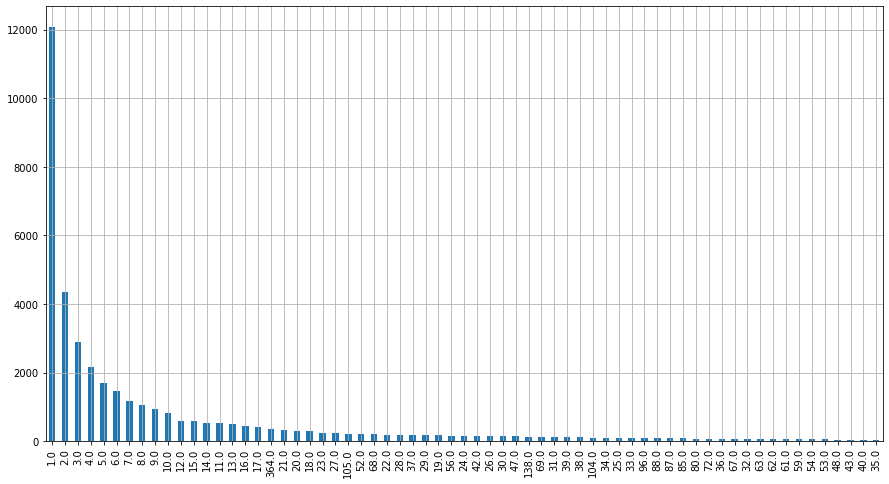

In [49]:
df['duplicate_count'].value_counts().plot(kind='bar', figsize=(15,8), grid=True)

Больше всего дубликатов среди строк с небольшим количеством дубликатов. Такая тенденция похожа на реальные покупки.

 Посмотрим, какие марки закупались большими партиями, информацию о возврате и аномальные значения в quantity.

Text(0.5, 1.0, 'Box Plot количества заказов')

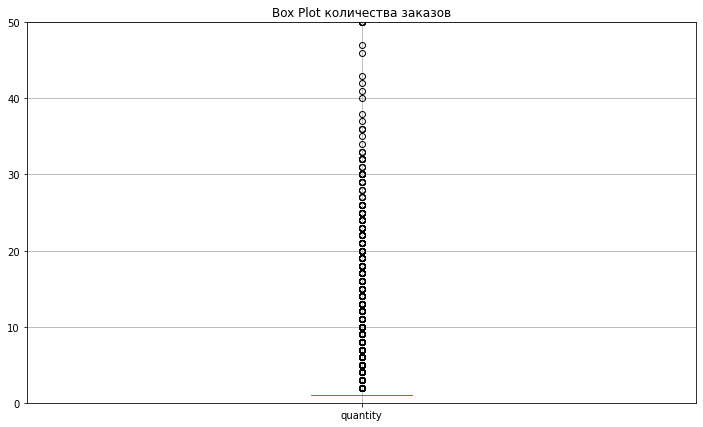

In [50]:
plt.figure(figsize=(12, 7))
df.boxplot('quantity')
plt.ylim(0,50)
plt.title('Box Plot количества заказов')

In [51]:
# Создадим копию датафрейма
#изучим аномальные  значения в quantity
display("Модель авто возврат:", df.query('quantity == -1')[['model', 'brand', 'sale_usd','quantity']])
print("Количество заказов с 1 машиной в чеке:", round((df.query('quantity == 1')['model'].count())/df['model'].count()*100, 2), "%")

display("Самые дорогие заказы с количеством авто в чеке больше 50:",df[['brand','model', 'quantity','sale_usd']].sort_values(by='sale_usd',ascending=False).head(15))
display("Модели, которые чаще всего покупают большими партиями:", df[['brand','model', 'quantity']].sort_values(by='quantity',ascending=False).head(15))

'Модель авто возврат:'

,model,brand,sale_usd,quantity
25725,Superb,Skoda,-35588.25,-1


Количество заказов с 1 машиной в чеке: 92.97 %


'Самые дорогие заказы с количеством авто в чеке больше 50:'

,brand,model,quantity,sale_usd
39555,Daewoo,BC 095,50,3.778206e+06
39547,Daewoo,BC 211 MA,30,3.157812e+06
39554,Daewoo,BC 095,30,2.277368e+06
20215,MAN,TG,20,2.004333e+06
25552,Skoda,Octavia,100,1.870000e+06
20211,MAN,TG,10,1.477016e+06
20219,MAN,TG,14,1.400791e+06
38403,Volkswagen,Polo,79,1.261460e+06
38705,Daewoo,BS 106 D,16,1.199778e+06
20346,Mercedes-Benz,G-Class,7,1.156569e+06


'Модели, которые чаще всего покупают большими партиями:'

,brand,model,quantity
16884,Lada,4x4,115
25552,Skoda,Octavia,100
38403,Volkswagen,Polo,79
13699,Jac,S3,70
16967,Lada,4x4,66
16299,Kia,Rio,63
38419,Volkswagen,Polo,62
38418,Volkswagen,Polo,62
16363,Kia,Rio,60
16857,Lada,4x4,54


* "-1" это точно возврат - цена Superb Skoda правда около 3.5 млн  
* большинство заказов (92.87 %)  1 машина в чеке  
* Больших заказов (от 50 машин в чеке) немного.

Самый дорогой заказ 3млн 778тыс. долларов - 50 штук Daewoo BC095 (городской автобус среднего класса).  
Чаще всего, самые дорогие оптовые заказы: городские автобусы и грузовики.   
Больше всего оптом покупают бюджетные и средние варианты (Lada, Volkswagen Polo, Kia Rio)
Среди больших партий нет моделей с наибольшим количеством дублей в строках (Toyota Camry и Ravon Nexia R3). Их реже покупают оптом.
   
Выбросы не похожи на аномалии, потому что наибольшие суммы в чеках - это оптовые продажами от 7 до 115 штук и значения выглядят правдободобно (сверяла с ценами), несколько дубликатных строк тоже попали в выбросы, но их сумма не превышает нормальные значения.  

In [52]:
#исключим возврат и посомтрим базовую статистику
pd.options.display.float_format = '{:.2f}'.format
df[df['quantity'] != -1][['quantity', 'price_usd','sale_usd']].agg(['min', 'max', 'median'])

,quantity,price_usd,sale_usd
min,1.00,7100.00,7100.00
max,115.00,328510.97,3778206.26
median,1.00,24580.02,26473.28


Так как среднее лучше использовать, когда нет выбросов, среднюю цену машины (price_usd) и цену заказа(sale_usd) оценим по медиане.     

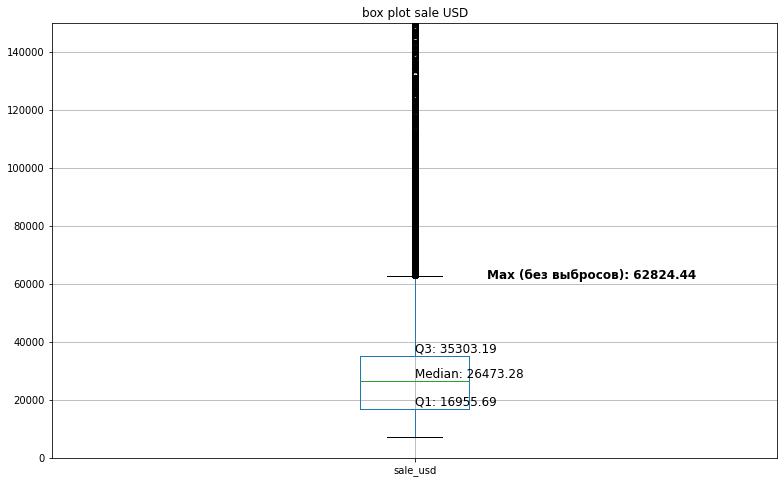

Процент выбросов: 8.94%


In [53]:
plt.figure(figsize=(13,8))
plt.ylim(0,150000)
df.boxplot(['sale_usd'])
# Получаем статистические значения для коробок
median = df['sale_usd'].median()
q1 = df['sale_usd'].quantile(0.25)
q3 = df['sale_usd'].quantile(0.75)
iqr = q3 - q1
# Добавляем подпись к выбранной коробке с медианой
plt.text(1, median, f'Median: {median:.2f}', fontsize=12, ha='left', va='bottom')
# Добавляем подписи к Q1 и Q3
plt.text(1, q1, f'Q1: {q1:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1, q3, f'Q3: {q3:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1.1, q3 + 1.5 * iqr, f'Max (без выбросов): {q3 + 1.5 * iqr:.2f}', ha='left', va='center', fontweight='bold', fontsize=12)
plt.title('box plot sale USD')
plt.show()
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr
outliers = df[(df['sale_usd'] < lower_whisker) | (df['sale_usd'] > upper_whisker)]
percentage_of_outliers = len(outliers) / len(df) * 100
print(f"Процент выбросов: {percentage_of_outliers:.2f}%")
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

Средний чек 25834 дол. 
Выбросы 9%, значит 9% покупок сильно превышали суммы средних чеков.  
Теперь посмотрим информацию о заказах с наибольшей выручкой (анализируем выбросы).

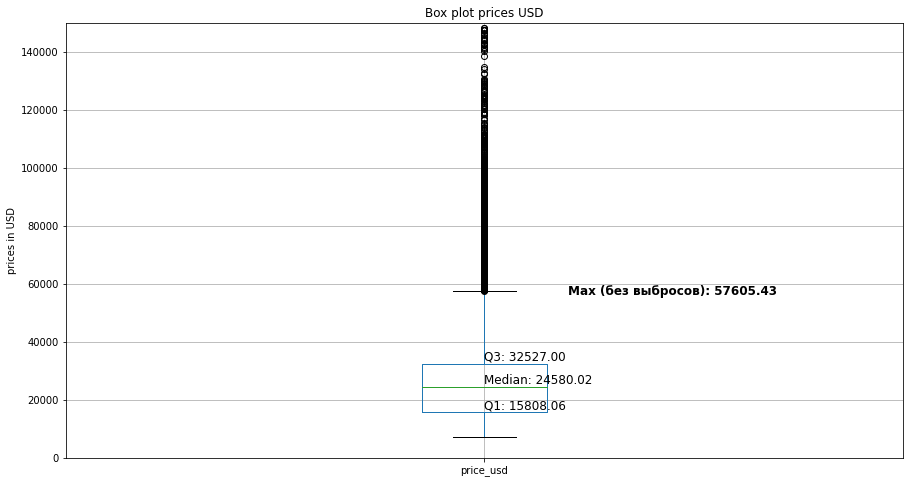

Процент выбросов: 7.21%


In [54]:
plt.figure(figsize=(15,8))
plt.ylim(0,150000)
df.boxplot(['price_usd'])
# Получаем статистические значения для коробок
median = df['price_usd'].median()
q1 = df['price_usd'].quantile(0.25)
q3 = df['price_usd'].quantile(0.75)
iqr = q3 - q1
# Добавляем подпись к выбранной коробке с медианой
plt.text(1, median, f'Median: {median:.2f}', fontsize=12, ha='left', va='bottom')
# Добавляем подписи к Q1 и Q3
plt.text(1, q1, f'Q1: {q1:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1, q3, f'Q3: {q3:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1.1, q3 + 1.5 * iqr, f'Max (без выбросов): {q3 + 1.5 * iqr:.2f}', ha='left', va='center', fontweight='bold', fontsize=12)
plt.ylabel('prices in USD')
plt.title('Box plot prices USD')
plt.show()
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr
outliers = df[(df['price_usd'] < lower_whisker) | (df['price_usd'] > upper_whisker)]
percentage_of_outliers = len(outliers) / len(df) * 100
print(f"Процент выбросов: {percentage_of_outliers:.2f}%")

В price_usd 7% выбросов. Средняя цена купленной машины 23920. Обычно цены купленных машин колеблются от 15600 до 32476.  
 Теперь изучим выбросы: помотрим какие бренды авто стоят дороже всего и выведем инфу о таких брендах.

,company,manufacturer_country,brand,model,price_usd,duplicate_count,date,class_2013
39842,Autokapital,DEU,Mercedes-Benz Trucks,Setra,328510.97,1.00,2019-07-31,Большие автобусы
20399,Autokapital,TUR,Mercedes-Benz Trucks,Tourismo,305252.02,1.00,2019-05-31,Большие автобусы
20400,Autokapital,TUR,Mercedes-Benz Trucks,Tourismo,303650.88,1.00,2019-06-30,Большие автобусы
9700,Hyundai Com Trans Kazakhstan,KAZ,Hyundai Truck & Bus,Universe,243388.74,1.00,2019-03-31,Большие автобусы
9705,Hyundai Com Trans Kazakhstan,KAZ,Hyundai Truck & Bus,Universe,242854.52,1.00,2019-09-30,Большие автобусы
9701,Hyundai Com Trans Kazakhstan,KAZ,Hyundai Truck & Bus,Universe,240826.56,2.00,2019-06-30,Большие автобусы
9704,Hyundai Com Trans Kazakhstan,KAZ,Hyundai Truck & Bus,Universe,239718.66,2.00,2019-07-31,Большие автобусы
18758,Almaty Motors Premium,UK,Land Rover,Range Rover,218681.74,1.00,2019-04-30,Полноразмерные SUV
18778,Almaty Motors Premium,UK,Land Rover,Range Rover,209414.40,1.00,2019-06-30,Полноразмерные SUV
9699,Hyundai Com Trans Kazakhstan,KOR,Hyundai Truck & Bus,Universe,207148.62,1.00,2019-01-31,Большие автобусы


Text(0, 0.5, 'Бренд авто')

<Figure size 1080x720 with 0 Axes>

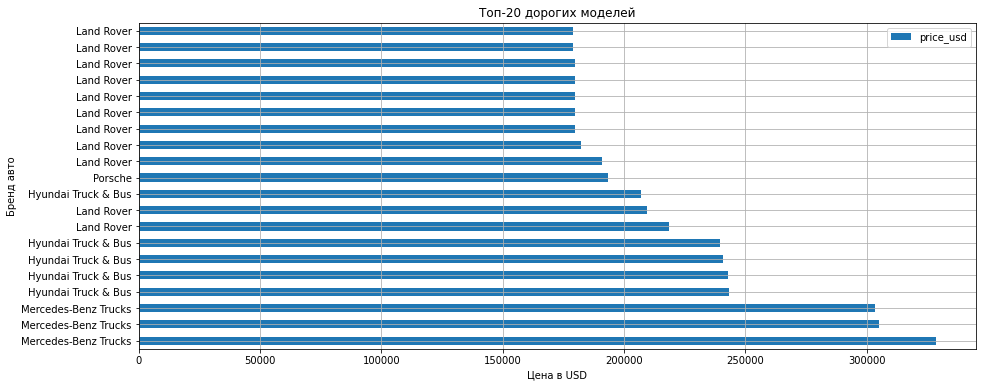

In [55]:
plt.figure(figsize=(15,10))
# Создаём DataFrame с выбросами price_usd и сортируем
outliers = df[(df['price_usd'] < lower_whisker) | (df['price_usd'] > upper_whisker)].sort_values(by='duplicate_count', ascending=False)
#отбираем столбцы для просмотра
str_max_sale_usd= outliers[['company', 'manufacturer_country', 'brand', 'model', 'price_usd','duplicate_count','date','class_2013']].sort_values(by='price_usd' ,ascending=False).drop_duplicates()
display(str_max_sale_usd.head(20))
#выводим график топ 20 самых дорогих марок на график
str_max_sale_usd.head(20).plot(x='brand', y='price_usd',kind='barh',figsize=(15,6), grid=True)
plt.title('Топ-20 дорогих моделей')
plt.xlabel('Цена в USD')
plt.ylabel('Бренд авто')

Наибольшие цены также выглядят адекватно, цены соответсвуют брендам (это авто повышенной комфортности, среди них: внедорожники, автобусы и грузовики).

Посмотрим распределение значений в sale_usd и price_usd с помощью hist, исключив сильные выбросы.

Корреляция между price_usd и sale_usd: 0.41


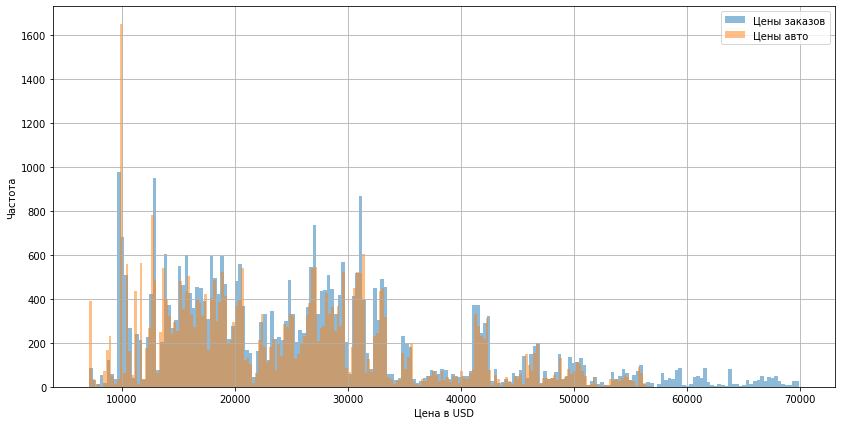

In [56]:
plt.figure(figsize=(14,7))
df.query('quantity!=-1&sale_usd < 70000')['sale_usd'].hist(bins=200, alpha=0.5, label='Цены заказов')
df.query('quantity!=-1&price_usd < 57000')['price_usd'].hist(bins=200, alpha=0.5, label='Цены авто')
plt.xlabel('Цена в USD')
plt.ylabel('Частота')
plt.legend()
print("Корреляция между price_usd и sale_usd:", round(df['price_usd'].corr(df['sale_usd']),2))

In [57]:
df.query(' 5000 > price_usd < 10000')['model'].count()

0

Исключив выбросы, по графику видно, что есть определённая зависимость между распределением price_usd и sale_usd, чем выше цена авто, тем больше сумма чека (в том случае, если берут несколько авто).  
Резкие скачки на графике говорят о том, что некоторых моделей может быть меньше или больше остальных по определённой цене. Больше всего авто ~ за 10 тыс.дол.

C:\Users\Redmi\AppData\Local\Temp\ipykernel_19140\3091449808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Text(0.5, 1.0, 'Уровень корреляции между столбцами')

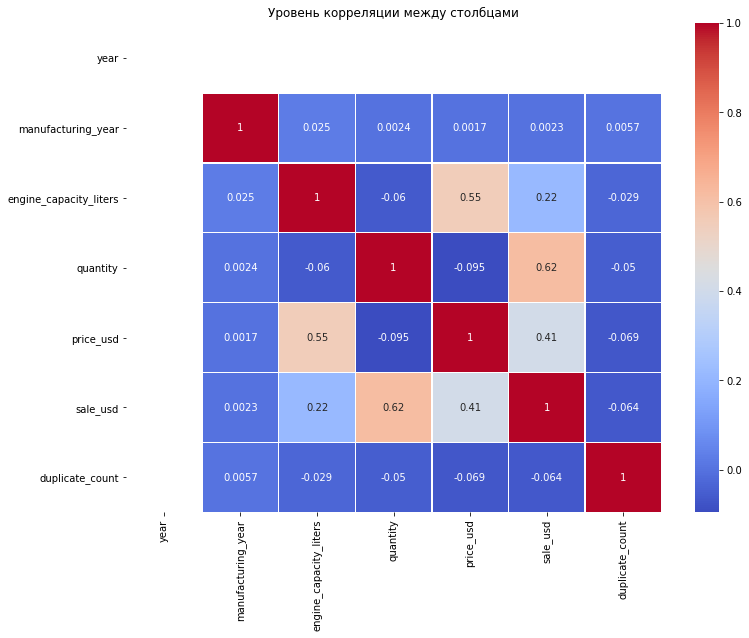

In [58]:
plt.figure(figsize=(12,9))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Уровень корреляции между столбцами')

Есть 2 корреляции выше среднего: количество авто/сумма заказа, цена авто/объём двигателя.  
Также есть корреляция чуть ниже среднего: цена авто/сумма заказа.  
Остальные корреляции незначительны.  

Теперь изучим столбец со значениями объёма двигателя на выбросы и избавимся от них.

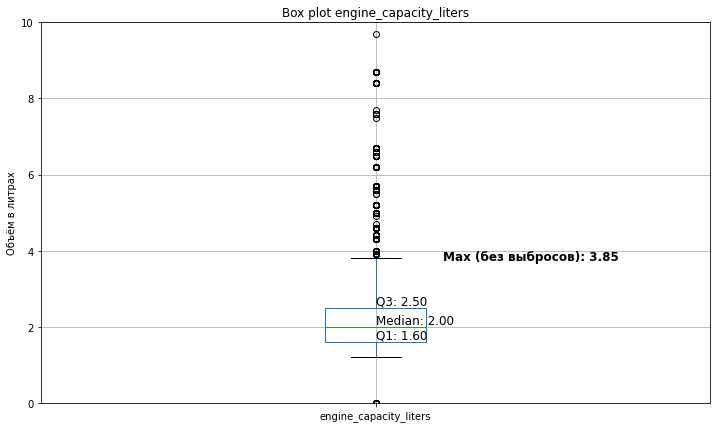

In [59]:
plt.figure(figsize=(12,7))
df.boxplot('engine_capacity_liters')
plt.ylim(0,10)
median = df['engine_capacity_liters'].median()
q1 = df['engine_capacity_liters'].quantile(0.25)
q3 = df['engine_capacity_liters'].quantile(0.75)
iqr = q3 - q1
# Добавляем подпись к выбранной коробке с медианой
plt.text(1, median, f'Median: {median:.2f}', fontsize=12, ha='left', va='bottom')
# Добавляем подписи к Q1 и Q3
plt.text(1, q1, f'Q1: {q1:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1, q3, f'Q3: {q3:.2f}', fontsize=12, ha='left', va='bottom')
plt.text(1.1, q3 + 1.5 * iqr, f'Max (без выбросов): {q3 + 1.5 * iqr:.2f}', ha='left', va='center', fontweight='bold', fontsize=12)
plt.ylabel('Объём в литрах')
plt.title('Box plot engine_capacity_liters')
plt.show()
#lower_whisker = q1 - 1.5 * iqr
#upper_whisker = q3 + 1.5 * iqr

In [60]:
#анализ выбросов в engine_capacity_liters
df.query('engine_capacity_liters > 10.0')[['brand','model','engine_capacity_liters']].drop_duplicates()

,brand,model,engine_capacity_liters
399,Chevrolet,Niva,26.70
400,Chevrolet,Niva,25.70
401,Chevrolet,Niva,24.70
402,Chevrolet,Niva,23.70
403,Chevrolet,Niva,22.70
404,Chevrolet,Niva,21.70
405,Chevrolet,Niva,20.70
406,Chevrolet,Niva,19.70
407,Chevrolet,Niva,18.70
408,Chevrolet,Niva,17.70


Много неверных значений у Chevrolet Niva, в реальности она имеет объём двигателя 1.7 и 1.8, заменим большие ошибочные значения на 1.7.   
Для всех остальных моделей значения объёмов двигателей впорядке.

In [61]:
#перезавпись значений объёмов двигателей для Сhevrolet Niva на верное
df.loc[(df['brand'] == 'Chevrolet') & (df['model'] == 'Niva'), 'engine_capacity_liters'] = 1.7


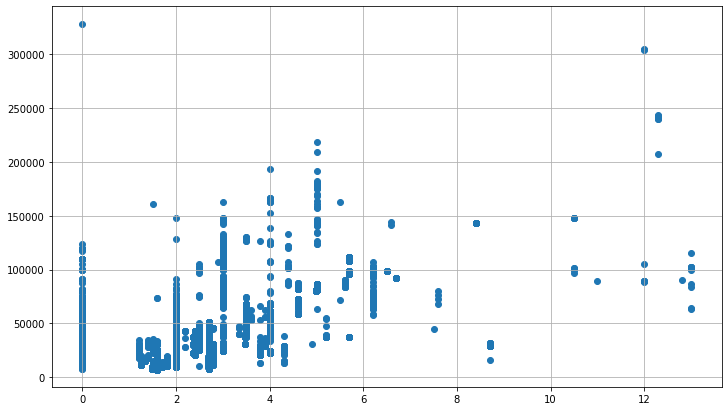

In [62]:
plt.figure(figsize=(12,7))
plt.scatter(df['engine_capacity_liters'], df['price_usd'])
plt.grid(True)

Больше всего автомобилей с объёмом двигателя от 1.7 до 6.2.   
Cтоимость авто с объёмом двиг. < 2 как правило не превышает 10 тыс.дол.  
В целом, есть тенденция - чем больше объём двигателя, тем выше цена.

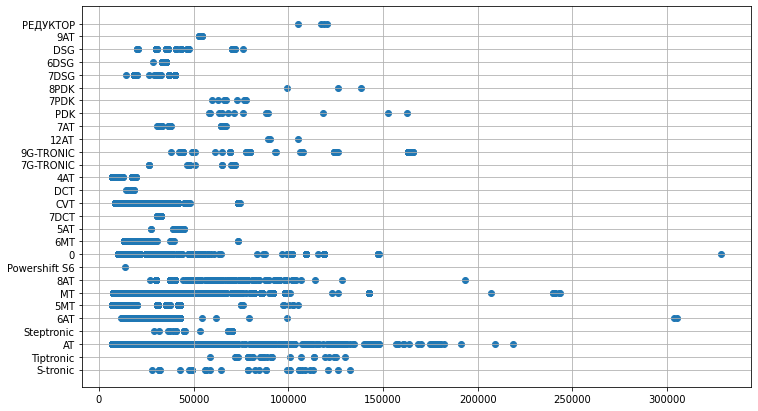

In [63]:
plt.figure(figsize=(12,7))
plt.scatter((df['price_usd']), df['transmission_type'])
plt.grid(True)

Больше всего дорогих моделей среди авто с автоматической трансмиссией.  
И в целом, на рынке Казахстана преобладают машины с автоматической коробкой передач.

**Вывод по разделу "исследовательский анализ".**
* Разобрались с дубликатами и решили *оставить* их:   
1) Наибольшее количество дубликатов у покупок из автоцентров Allur Auto, Ravon Motors Kazakstan, Toyota Motor Kazakhstan, это связано с тем, что это популярные автоцентры.  
2) Суммарно наибольшее количество дублей среди строк с моделями Ravon Nexia R3, Toyota Camry, Jac S3 (популярные модели средней цены).   
3) В целом, чаще всего дублировались довольно простые и бюджетные авто, есть стабильность по месяцам.  

*По результатам анализа дубликатов можно сказать, что скорее всего они - не ошибка при сборе данных, а реальные продажи с одинаковыми характеристиками.*   
* Проанализировали выбросы в quantity:  
1) Самый большой оптовый заказ: 115 штук Lada 4x4.
2) Наибольшими партиями покупают бюджетные и средние варианты авто (Lada, Volkswagen Polo, Kia Rio).
3) Самые дорогие оптовые заказы: городские автобусы и грузовики.     
4) Среди больших оптовых партий нет моделей с наибольшим количеством дублей в строках (Toyota Camry и Ravon Nexia R3), значит, чаще всего их берут для личного пользования.  
* Проанализировлаи выбросы в sale_usd:  
1) Самый дорогой заказ 3млн 778тыс. долларов - 50 штук Daewoo BC095 (городской автобус среднего класса).  
2) В выбросах самые дорогие заказы - оптовые.  
2) Самые дорогие заказы делают юр.лица.
3) Средний чек 25834 дол.  
* Выбросы в price_usd: 
1) Самое дорогое авто - автобус Mercedes-benz Trunk Setra 328510.97$. 
2) В целом, высокие цены соответсвуют моделям (бизнес-класс, автобусы, грузовики).
3) Чаще всего покупают авто по ценам от 15600$ до 32476$.
2) Средняя цена машины 23930 дол.  

*Выбросы в quantity, sale_usd, price_usd - не аномалии.*

* Есть 2 корреляции выше среднего: 
1) Cумма заказа/количество авто.    
2) Цена авто/объём двигателя (есть тенденция - чем больше объём двигателя, тем выше цена).

## 3 Анализ рынка

### 3.1 Топовые марки и продажи на рынке Казахстана.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(Camry, Toyota)'),
  Text(1, 0, '(Tucson, Hyundai)'),
  Text(2, 0, '(Accent, Hyundai)'),
  Text(3, 0, '(Elantra, Hyundai)'),
  Text(4, 0, '(Creta, Hyundai)'),
  Text(5, 0, '(LC Prado, Toyota)'),
  Text(6, 0, '(Nexia R3, Ravon)'),
  Text(7, 0, '(S3, Jac)'),
  Text(8, 0, '(RAV4, Toyota)'),
  Text(9, 0, '(Corolla, Toyota)')])

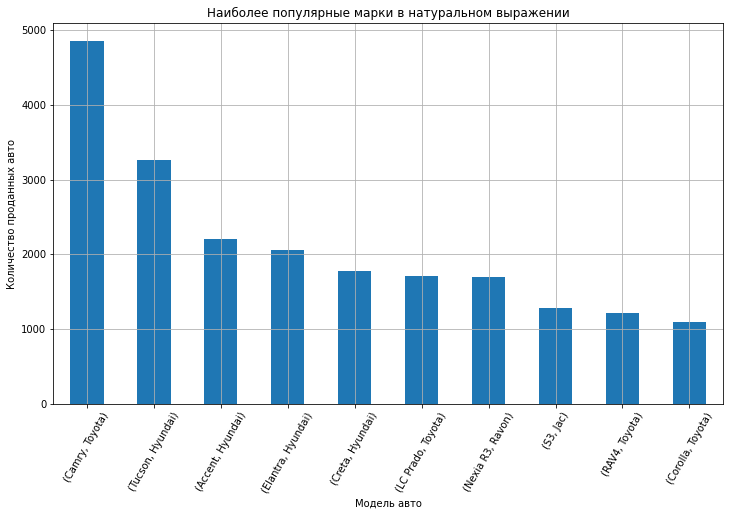

In [84]:
#построим график наибольшего количества проданных моделей
plt.figure(figsize=(12, 7))
df.groupby(['model','brand'])['model'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,7), grid=True)
plt.title('Наиболее популярные марки в натуральном выражении')
plt.xlabel('Модель авто')
plt.ylabel('Количество проданных авто')
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '(Camry, Toyota)'),
  Text(1, 0, '(Tucson, Hyundai)'),
  Text(2, 0, '(LC Prado, Toyota)'),
  Text(3, 0, '(LC200, Toyota)'),
  Text(4, 0, '(Elantra, Hyundai)'),
  Text(5, 0, '(Accent, Hyundai)'),
  Text(6, 0, '(Creta, Hyundai)'),
  Text(7, 0, '(Corolla, Toyota)'),
  Text(8, 0, '(RAV4, Toyota)'),
  Text(9, 0, '(LX, Lexus)')])

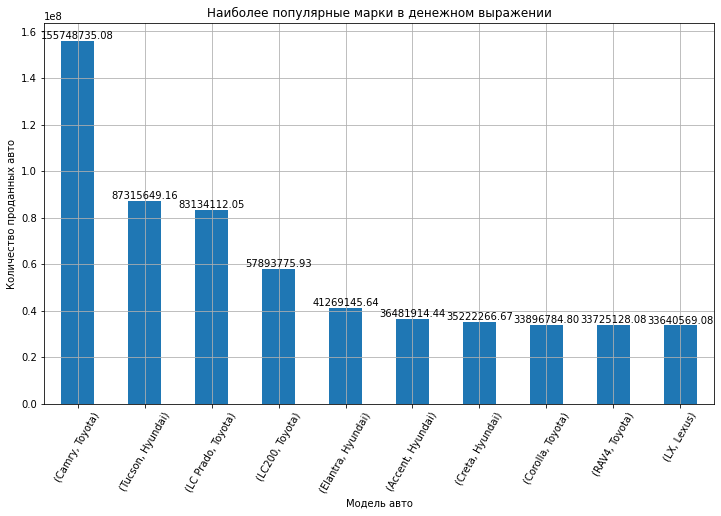

In [86]:
plt.figure(figsize=(12, 7))
top_10_models = df.groupby(['model','brand'])['sale_usd'].sum().sort_values(ascending=False).head(10)
top_10_models.plot(kind='bar', grid=True)
plt.title('Наиболее популярные марки в денежном выражении')
plt.xlabel('Модель авто')
plt.ylabel('Количество проданных авто')
# Добавляем числа на график
for index, value in enumerate(top_10_models):
    plt.annotate(f'{value:.2f}', xy=(index, value), ha='center', va='bottom')
plt.xticks(rotation=60)

Наиболее популярная модель Toyota Camry, затем идут Hunday Tucson,  Hunday Accent и т.д.  
В целом, наиболее популярные бредны Hynday и Toyota, они же приносят больше всего выручки.   
Больше всего выручки с Toyota Camry (135 млн 317 тыс).

### 3.2 Динамика продаж в целом по рынку (помесячно).

Text(0, 0.5, 'Количество проданных авто')

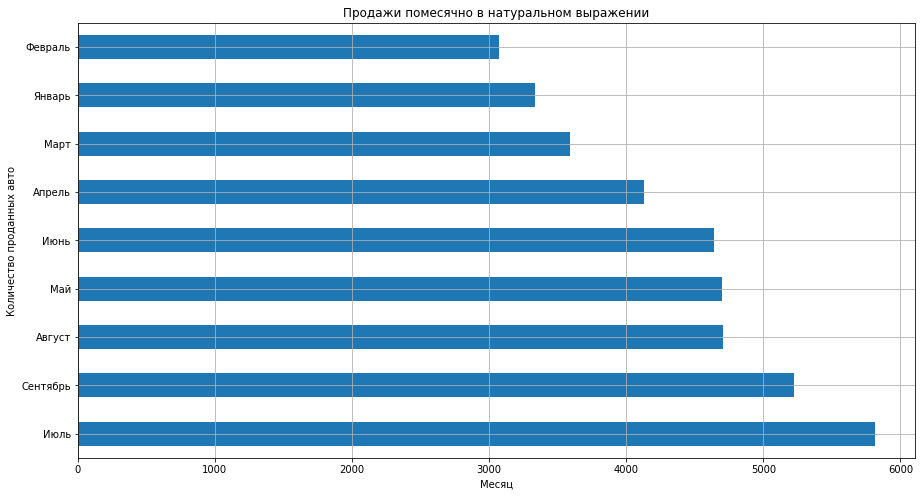

In [67]:
plt.figure(figsize=(15, 8))
df.groupby('month')['model'].count().sort_values(ascending=False).plot(kind='barh', grid=True)
plt.title('Продажи помесячно в натуральном выражении')
plt.xlabel('Месяц')
plt.ylabel('Количество проданных авто')

Text(0, 0.5, 'Сумма продаж, USD')

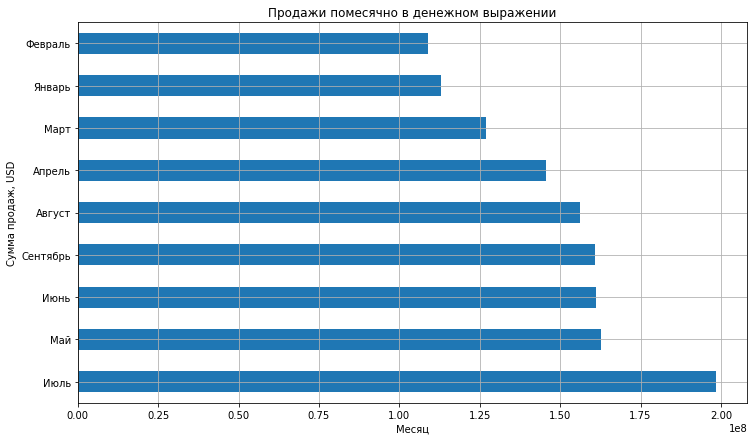

In [68]:
plt.figure(figsize=(14, 7))
df.groupby('month')['sale_usd'].sum().sort_values(ascending=False).plot(kind='barh', figsize=(12,7), grid=True)
plt.title('Продажи помесячно в денежном выражении')
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж, USD')

Пик продаж приходится на апрель-сентябрь. В марте наименьшее количество продаж.

### 3.3 Динамика продаж по категориям (помесячно): тип топлива, класс, сегмент 

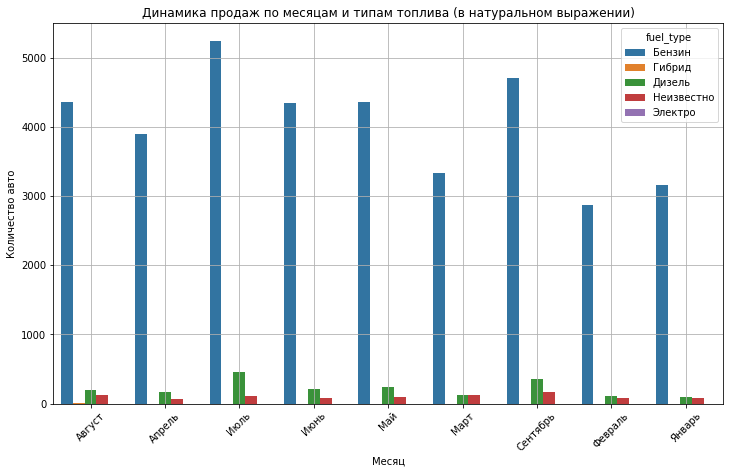

In [81]:
# Группируем данные по месяцам и категории fuel_type, считаем сумму продаж в денежном выражении
monthly_sales = df.groupby(['month', 'fuel_type'])['model'].count().reset_index()
plt.figure(figsize=(12, 7))
sns.barplot(data=monthly_sales, x='month', y='model', hue='fuel_type')
plt.title('Динамика продаж по месяцам и типам топлива (в натуральном выражении)')
plt.xlabel('Месяц')
plt.ylabel('Количество авто')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Больше всего продаются машины с Бензо движком и их больше всего на рынке (около 90%)

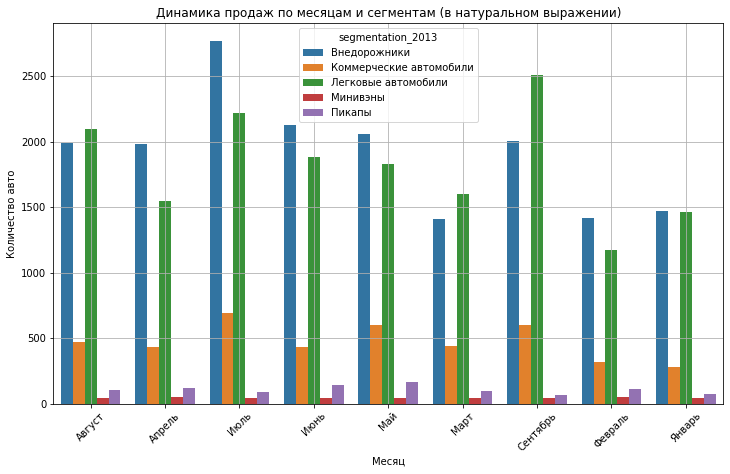

In [82]:
# Группируем данные по месяцам и сегментации, считаем сумму продаж в денежном выражении
monthly_sales = df.groupby(['month', 'segmentation_2013'])['model'].count().reset_index()
plt.figure(figsize=(12, 7))
sns.barplot(data=monthly_sales, x='month', y='model', hue='segmentation_2013')
plt.title('Динамика продаж по месяцам и сегментам (в натуральном выражении)')
plt.xlabel('Месяц')
plt.ylabel('Количество авто')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На Казахстанском рынке преобладают внедорожники. Они же приносят больше всего выручки. За ними идут легковые авто.

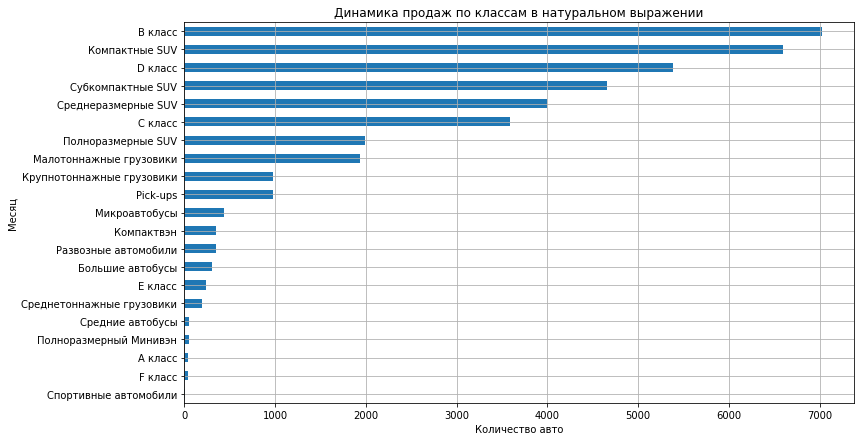

In [71]:
# Группируем данные по месяцам и сегментации, считаем количество проданных авто
monthly_sales = df.groupby('class_2013')['model'].count().sort_values()
monthly_sales.plot(x='class_2013', y='model', kind='barh', figsize=(12, 7),grid=True)
plt.title('Динамика продаж по классам в натуральном выражении')
plt.xlabel('Количество авто')
plt.ylabel('Месяц')
plt.show()

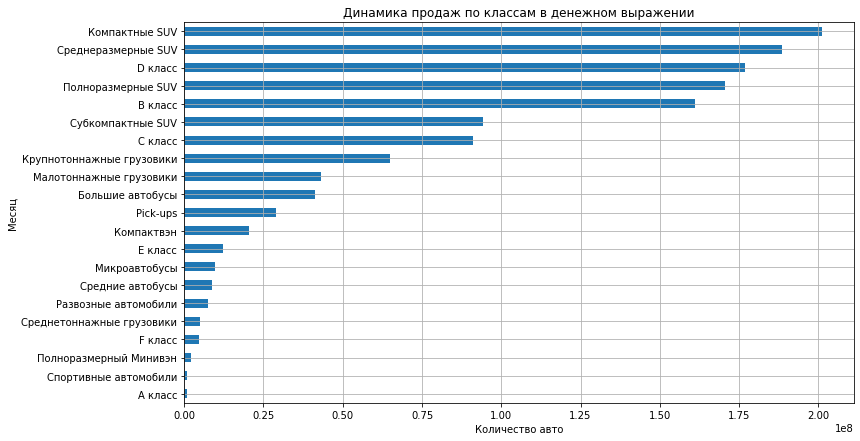

In [72]:
# Группируем данные по месяцам и сегментации, считаем сумму продаж в денежном выражении
monthly_sales = df.groupby('class_2013')['sale_usd'].sum().sort_values()
monthly_sales.plot(x='class_2013', y='model', kind='barh', figsize=(12, 7), grid=True)
plt.title('Динамика продаж по классам в денежном выражении')
plt.xlabel('Количество авто')
plt.ylabel('Месяц')
plt.show()

Наиболее популярные авто B класса, компактные SUV и авто D класса.  
Больше всего выручки было с компактных, среднеразмерных и полноразмерных SUV. 

### 3.4 Продажи по регионам 

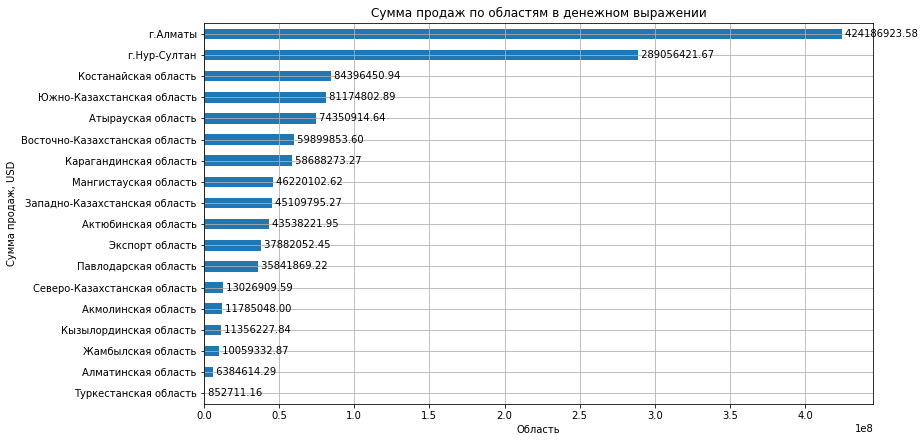

In [83]:
plt.figure(figsize=(12, 7))
sale_region = df.groupby('area')['sale_usd'].sum().sort_values()
ax = sale_region.plot(kind='barh', figsize=(12,7), grid=True)
plt.title('Сумма продаж по областям в денежном выражении')
plt.xlabel('Область')
plt.ylabel('Сумма продаж, USD')
for i, v in enumerate(sale_region):
    ax.text(v, i, f' {v:.2f}', va='center')

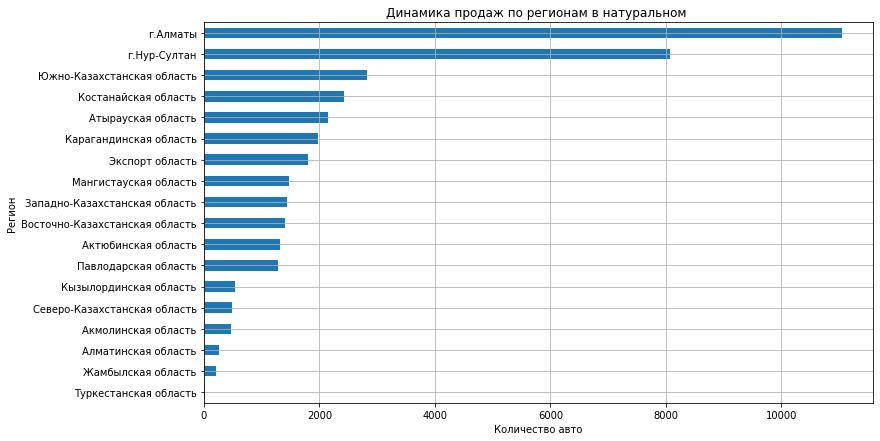

In [74]:
plt.figure(figsize=(12, 7))
df.groupby('area')['model'].count().sort_values().plot(kind='barh', grid=True)
plt.title('Динамика продаж по регионам в натуральном ')
plt.xlabel('Количество авто')
plt.ylabel('Регион')
plt.show()

Небольшая часть продаж на экспорт (около 36,6 млн дол.), основная масса покупателей - в Казахстане, больше всего машин было продано в г.Алматы (на сумму более 404 млн долларов).

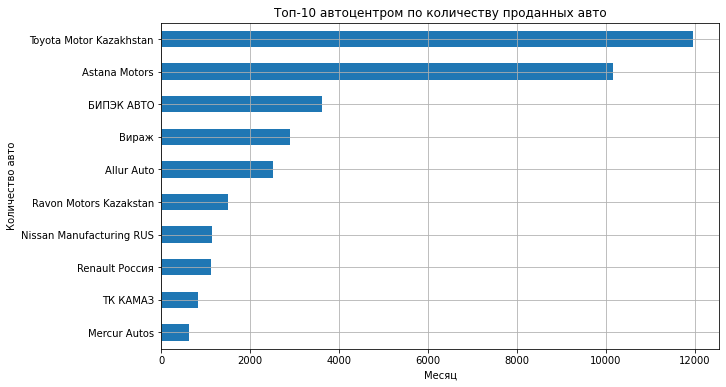

In [75]:
plt.figure(figsize=(12, 7))
top_10_companies = df.groupby('company')['model'].count().sort_values().tail(10)
ax = top_10_companies.plot(kind='barh', figsize=(10, 6), grid=True) 
plt.title('Топ-10 автоцентром по количеству проданных авто')
plt.xlabel('Месяц')
plt.ylabel('Количество авто')
plt.show()

С сильным отрывом от конкурентов наибольшее количество автомобилей продали Toyota Motor Kazahstan(более 10 тысяч) и Astana Motors(чуть более 10 тысяч), затем идёт БИПЭК АВТО и т.д.

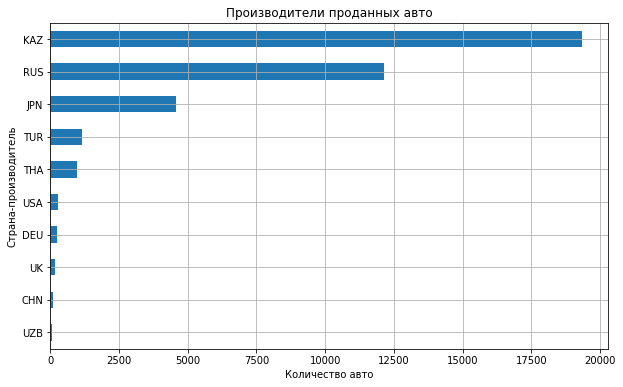

In [76]:
plt.figure(figsize=(12, 7))
top_10_mon_coun = df.groupby('manufacturer_country')['model'].count().sort_values().tail(10)
ax = top_10_mon_coun.plot(kind='barh', figsize=(10, 6), grid=True) 
plt.title('Производители проданных авто')
plt.xlabel('Количество авто')
plt.ylabel('Страна-производитель')
plt.show()



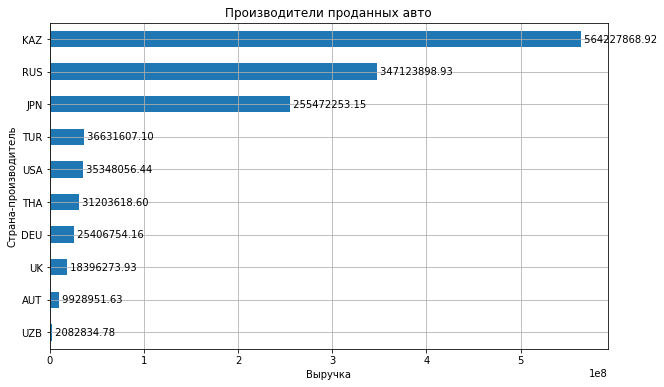

In [77]:
plt.figure(figsize=(12, 7))
top_10_mon_coun = df.groupby('manufacturer_country')['sale_usd'].sum().sort_values().tail(10)
ax = top_10_mon_coun.plot(kind='barh', figsize=(10, 6), grid=True) 
plt.title('Производители проданных авто')
plt.xlabel('Выручка')
plt.ylabel('Страна-производитель')

# Добавляем цифры на бары
for i, v in enumerate(top_10_mon_coun):
    ax.text(v, i, f' {v:.2f}', va='center')
plt.show()

На рынке Казахстана лидируют отечественные производители, затем идёт Россия и Япония.   
Авто этих производителей принесли больше всего денег (KAZ- более 564 млн дол, RUS - более 322 млн дол.)  

## Вывод. 
В ходе исследования датасет был подготовлен к анализу рынка: провелась очистка данных от аномалий и дубликатов, изменены типы данных, устранены пропуски, проанализированы выбросы. В результате получены такие выводы:  
* Средняя цена машины - 23930 дол.
* Средний чек - 25834 дол.    .  
* Больше всего оптом покупают бюджетные и средние варианты (Lada, Volkswagen Polo, Kia Rio).  
* Наиболее популярные модели: Toyota Camry (куплено на сумму 135 млн), Hunday Tucson,  Hunday Accent.  
* В целом, наиболее популярные бредны, которые приносят больше всего выручки: Toyota (куплено на 361 млн) и Hynday (229 млн).  
* Лишь небольшая часть авто идёт на экспорт (менее 2х тысяч авто). Больше всего было продано в г.Алматы (на сумму более 404х млн долларов).  
* Пик продаж приходится на апрель-сентябрь. В марте наименьшее количество продаж.  
* Больше всего продаются машины с Бензо движком и их больше всего на рынке (около 90%).
* На Казахстанском рынке преобладают внедорожники. Они же приносят больше всего выручки. За ними идут легковые авто. 
* Наиболее популярные авто B класса, компактные SUV и авто D класса. Больше всего выручки - с компактных, среднеразмерных и полноразмерных SUV.    
* Наиболее популярные автоцентры: Toyota Motor Kazahstan(продали более 10 тысяч) и Astana Motors(чуть более 10 тысяч), затем идёт БИПЭК АВТО и т.д.
* Больше всего проданных автомобилей собраны в Казахстане (около 19 тыс.), затем идёт Россия и Япония.    